<a href="https://colab.research.google.com/github/Depersonalizc/AL-cancer-detection/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC4080 Midterm Project
## 📝Active Learning for Label-Efficient Histopathologic Cancer Detection


*Group 24* 

- 🐷 CHEN Ang   (118010009)

- 🐸 FU Quanzhi (118010070)








## Prepare data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

!unzip gdrive/Shareddrives/c012-153/data/histopathologic-cancer-detection.zip -d ./data/

Streaming output truncated to the last 5000 lines.
  inflating: ./data/train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: ./data/train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: ./data/train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: ./data/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: ./data/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: ./data/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: ./data/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: ./data/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: ./data/train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: ./data/train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: ./data/train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: ./data/train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: ./data/train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  


In [1]:
%matplotlib inline
import pandas as pd
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
plt.rcParams["figure.figsize"] = (5, 3) # (w, h)
plt.rcParams["figure.dpi"] = 200

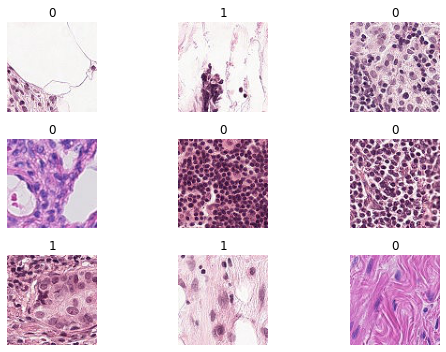

In [2]:
df = pd.read_csv("./data/train_labels.csv")
fig = plt.figure(figsize=(8,5))
for i in range(9):
    fig.add_subplot(3, 3, i + 1)
    fname = f"./data/train/{df.id[i]}.tif"
    plt.imshow(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB))
    plt.title(df.label[i]); plt.axis("off")
fig.tight_layout()

In [3]:
from concurrent import futures
from functools import partial
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset


def pmap(f, iterable, max_threads=None, show_pbar=False, **kwargs):
    """Concurrent version of map()."""
    with futures.ThreadPoolExecutor(max_threads) as executor:
      if show_pbar:
        results = tqdm(executor.map(f, iterable, **kwargs))
      else:
        results = executor.map(f, iterable, **kwargs)
      return list(results)


class HistopathologicDataset(Dataset):
    def __init__(self, df, datadir, transform=None):
        fnames = [f"{datadir}/{i}.tif" for i in df.id]
        labels = df.label.tolist()

        def get_xy(idx):
            x = cv2.imread(fnames[idx])
            y = labels[idx]
            return x, y

        self.items = pmap(get_xy, range(len(df)), show_pbar=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, index):
        img, label = self.items[index]
        if self.transform:
            img = self.transform(img)
        return img, label


In [4]:
from torchvision import transforms, models

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.CenterCrop((49, 49)),
    transforms.ToTensor(),
    normalize,
])

valid_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop((49, 49)),
    transforms.ToTensor(),
    normalize,
])

# df = df[:500]
split = int(0.8 * len(df))
batch_size = 128
val_batch_size = 1024
train_dataset = HistopathologicDataset(df[:split], "./data/train", train_transforms)
valid_dataset = HistopathologicDataset(df[split:], "./data/train", valid_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=val_batch_size)

176020it [01:35, 1842.88it/s]
44005it [00:30, 1456.47it/s]


## Model

In [5]:
from torch import nn

resnet = models.resnet50(pretrained=True)

in_features = resnet.fc.in_features
num_hidden = 512

head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.BatchNorm1d(in_features),
    nn.Dropout(0.5),
    nn.Linear(in_features=in_features, out_features=num_hidden),
    nn.ReLU(),
    nn.BatchNorm1d(num_hidden),
    nn.Dropout(0.5),
    nn.Linear(in_features=num_hidden, out_features=2),
)

model = nn.Sequential(
    nn.Sequential(*list(resnet.children())[:-2]),
    head
)


## Training

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def train(train_loader, model, criterion, optimizer, scheduler):
    total_loss = 0.0
    size = len(train_loader.dataset)
    num_batches = size // train_loader.batch_size
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        print(f"Training: {i}/{num_batches}")
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images) # forward pass
        loss = criterion(outputs, labels)
        total_loss += loss.item() * images.size(0)
        optimizer.zero_grad()
        loss.backward()  # backprogagation
        optimizer.step()
        # scheduler.step()
    scheduler.step()
    return total_loss / size


def validate(valid_loader, model, criterion):
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_loss = 0.0
        size = len(valid_loader.dataset)
        num_batches = size // valid_loader.batch_size
        for i, (images, labels) in enumerate(valid_loader):
            print(f"Validation: {i}/{num_batches}")
            
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)
            total_loss += loss.item() * images.size(0)
            
        return total_loss / size, total_correct.double() / size


def fit(model, num_epochs, train_loader, valid_loader):
    from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # scheduler = OneCycleLR(optimizer, max_lr=1e-2, epochs=num_epochs, steps_per_epoch=len(train_loader))
    scheduler = CosineAnnealingLR(optimizer, len(train_loader)*.9, 1e-4)
    print("epoch\ttrain loss\tvalid loss\taccuracy")
    for epoch in range(num_epochs):
        train_loss = train(train_loader, model, criterion, optimizer, scheduler)
        valid_loss, valid_acc = validate(valid_loader, model, criterion)
        print(f"{epoch}\t{train_loss:.5f}\t\t{valid_loss:.5f}\t\t{valid_acc:.3f}")

In [8]:
model = model.to(device)
fit(model, 20, train_loader, valid_loader)

Streaming output truncated to the last 5000 lines.
Training: 680/1375
Training: 681/1375
Training: 682/1375
Training: 683/1375
Training: 684/1375
Training: 685/1375
Training: 686/1375
Training: 687/1375
Training: 688/1375
Training: 689/1375
Training: 690/1375
Training: 691/1375
Training: 692/1375
Training: 693/1375
Training: 694/1375
Training: 695/1375
Training: 696/1375
Training: 697/1375
Training: 698/1375
Training: 699/1375
Training: 700/1375
Training: 701/1375
Training: 702/1375
Training: 703/1375
Training: 704/1375
Training: 705/1375
Training: 706/1375
Training: 707/1375
Training: 708/1375
Training: 709/1375
Training: 710/1375
Training: 711/1375
Training: 712/1375
Training: 713/1375
Training: 714/1375
Training: 715/1375
Training: 716/1375
Training: 717/1375
Training: 718/1375
Training: 719/1375
Training: 720/1375
Training: 721/1375
Training: 722/1375
Training: 723/1375
Training: 724/1375
Training: 725/1375
Training: 726/1375
Training: 727/1375
Training: 728/1375
Training: 729/1375